In [1]:
import cv2,os
from skimage import io
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve

import torch
from torch.utils.data import Dataset,TensorDataset,random_split,DataLoader,SubsetRandomSampler
from torch.utils.data.dataset import Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [2]:
chip="H3K27ac"
X_Ctrl = np.load("./Datasets/Ctrl_"+chip+".npy",allow_pickle=True)
X_VPA = np.load("./Datasets/VPA_"+chip+".npy",allow_pickle=True)
y_Ctrl = torch.zeros(len(X_Ctrl), dtype=torch.int64)
y_VPA = torch.ones(len(X_VPA), dtype=torch.int64)
X = np.concatenate((X_Ctrl, X_VPA), axis = 0)
y = torch.cat((y_Ctrl, y_VPA), 0)

# 2. Data processing

In [ ]:
class cell_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]).to(torch.float), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

dataset = cell_dataset(X, y)

In [5]:
batch_size = 64
train_size = int(len(X)*0.8)
valid_size = len(X) - train_size

train_data, valid_data = random_split(dataset=dataset, lengths=[train_size, valid_size], 
                                      generator=torch.Generator().manual_seed(42))
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

# 3. ResNet model

In [8]:
homepath="/groups/4/gaa50089/acd13264yb/Epigenetic/Classification"
modelpath=homepath+"/Models/"
resnet="Resnet10_noavg"
chip="H3K27ac"

In [10]:
weight=torch.load(modelpath+resnet+"_"+chip+"/Fold4.pkl")
print(modelpath+resnet+"_"+chip+".pkl")
if resnet=="Resnet10_noavg":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.avgpool = nn.Sequential()
            self.resnet.fc = nn.Linear(128*75*75, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet10":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.fc = nn.Linear(128, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet18":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.fc = nn.Linear(512, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
    
model = ResNet().to(device)

/groups/4/gaa50089/acd13264yb/Epigenetic/Classification/Models/Resnet10_noavg_H3K27ac.pkl


In [9]:
ngpu = 4
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

In [10]:
image_size = 600
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())

torch.Size([1, 2])


# 4. Train

In [11]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

def train(model,device,dataloader_train,loss_function,optimizer):
    losses_train = []
    n_train = 0
    acc_train = 0
    optimizer.step()
    model.train()
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        acc_train += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_train.append(loss.tolist())
    return np.mean(losses_train), (acc_train/n_train)
        
def valid(model,device,dataloader_valid,loss_function):
    losses_valid = []
    n_val = 0
    acc_val = 0
    model.eval()
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    return np.mean(losses_valid), (acc_val/n_val)

history = {'loss_train': [], 'loss_valid': [],'acc_train':[],'acc_valid':[]}

In [13]:
n_epochs = 1
for epoch in range(n_epochs):
    loss_train, acc_train = train(model,device,dataloader_train,loss_function,optimizer)
    loss_valid, acc_valid = valid(model,device,dataloader_valid,loss_function)
    scheduler.step()
    
    history['loss_train'].append(loss_train)
    history['loss_valid'].append(loss_valid)
    history['acc_train'].append(acc_train)
    history['acc_valid'].append(acc_valid)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch, loss_train, acc_train, loss_valid, acc_valid))

EPOCH: 0, Train [Loss: 0.008, Accuracy: 0.998], Valid [Loss: 0.005, Accuracy: 0.998]


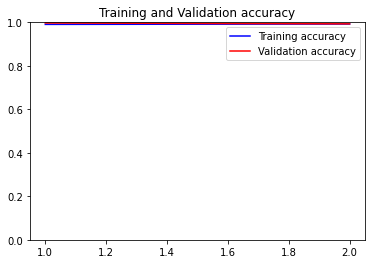

<Figure size 432x288 with 0 Axes>

In [32]:
# train processing plot
n_epochs = 50
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs, history['acc_train'], 'b', label='Training accuracy')  
plt.plot(epochs, history['acc_valid'], 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 4. Validate data

Resnet18_Hoechst
accuracy_score: 0.452
precision_score: 0.000
roc_auc_score: 0.954
total_test: 1313


/home/acd13264yb/python7_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


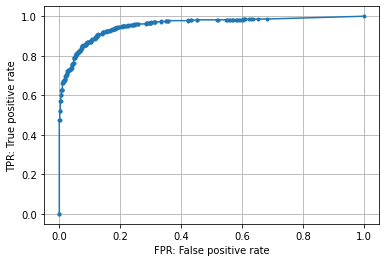

In [71]:
y = []
y_pred = []
out_pred = []
total = len(valid_data)

model.eval()
for n in range(total):
    img = valid_data[n][0]
    label = valid_data[n][1][1].item()
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = output.argmax(1).cpu().item()
    out_pred.append(output[0][1].item())
    y_pred.append(pred)
    y.append(label)

y = np.array(y)
y_pred = np.array(y_pred)
out_pred = np.array(out_pred)
print(resnet+"_"+chip)
print('accuracy_score: {:.3f}'.format(accuracy_score(y,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y,out_pred)))
print("total_test: {:}" .format(total))
fpr, tpr, thresholds = roc_curve(y, out_pred,drop_intermediate=True)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 99. Save model

In [24]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.module.resnet.state_dict(),"Models/Resnet_H3K27ac.pkl")

In [6]:
class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.avgpool = nn.Sequential()
            self.resnet.fc = nn.Linear(128*75*75, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
model = ResNet()

/home/acd13264yb/python10_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'weight' is not defined